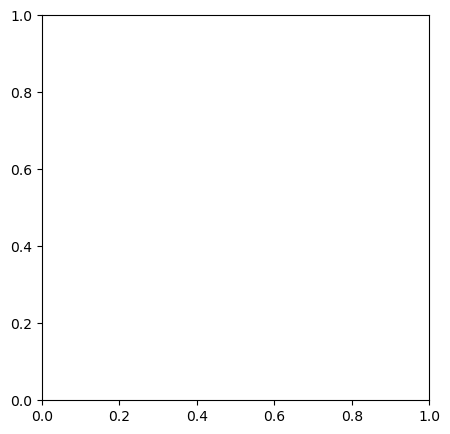

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../../../')
import Dataset_load 
from scipy.interpolate import interp2d

from  Dataset_Setup import Setup, GaussianCovariance_matrix
savefig = 1
picformat = "png"
fig, a_fake = plt.subplots(1, 1, figsize=(5.0, 5.0))

In [2]:
def compute_fraction(Ls_new, x_new, y_new, threshold, plot=False):
    tot_int = np.sum(Ls_new)
    offset = Ls_new.min() + threshold
    inside = Ls_new * (Ls_new >= offset)
    fraction_inside = np.sum(inside) / tot_int
    if plot:
        fig, ax = plt.subplots(
            1,
            1,
        )
        im = ax.pcolormesh(x_new, y_new, Ls_new)
        fig.colorbar(im)
        ax.set_title(f"frac inside : {fraction_inside * 100:.4} %")

        ax.contour(
            x_new, y_new, Ls_new, colors=("gold",), levels=[Ls_new.min() + threshold]
        )
    return fraction_inside


def plot_L(
    Ls_new,
    x_new,
    y_new,
    threshold,
    find_min,
    color="red",
    ax=None,
    fig=None,
    cbar=True,
    cmap="viridis",
):
    index_min, index_max, ampli_min, ampli_max, index_best, ampli_best = compute_errors(
        Ls_new, x_new, y_new, threshold, find_min=find_min
    )
    if ax is None:
        fig, ax = plt.subplots(
            1,
            1,
        )

    im = ax.pcolormesh(x_new, y_new, Ls_new, cmap=cmap, rasterized=True)
    if cbar:
        fig.colorbar(im)

    CS = ax.contour(
        x_new, y_new, Ls_new, colors=(color,), levels=[Ls_new.min() + threshold]
    )
    # ax.clabel(CS, CS.levels, inline=True, fmt='$1\\sigma$', fontsize=12)

    plot_errors(
        ax,
        x_new,
        y_new,
        index_min,
        index_max,
        ampli_min,
        ampli_max,
        index_best,
        ampli_best,
        color,
    )

    ax.plot(ampli_best, index_best, "x", color=color)

    ax.set_ylabel(f"Amplitude [{a_unit}]")
    ax.set_xlabel("Index []")
    return CS


def plot_errors(
    ax,
    x_new,
    y_new,
    index_min,
    index_max,
    ampli_min,
    ampli_max,
    index_best,
    ampli_best,
    color,
):
    linewidth = 2

    ax.hlines(
        y=index_min,
        xmin=x_new[0],
        xmax=x_new[-1],
        color=color,
        linestyle="dotted",
        linewidth=linewidth,
    )
    ax.hlines(
        y=index_max,
        xmin=x_new[0],
        xmax=x_new[-1],
        color=color,
        linestyle="dotted",
        linewidth=linewidth,
    )

    ax.vlines(
        x=ampli_min,
        ymin=y_new[0],
        ymax=y_new[-1],
        color=color,
        linestyle="dotted",
        linewidth=linewidth,
    )
    ax.vlines(
        x=ampli_max,
        ymin=y_new[0],
        ymax=y_new[-1],
        color=color,
        linestyle="dotted",
        linewidth=linewidth,
    )


def compute_errors(Ls_new, x_new, y_new, threshold, find_min):
    offset = Ls_new.min() + threshold
    if offset > 0:
        inside = Ls_new * (Ls_new < offset)
    else:
        inside = Ls_new * (Ls_new >= offset)
    if find_min:  # find min:
        pos = np.where(inside > 0)
        ampli_best = x_new[np.where(Ls_new == Ls_new.min())[1][0]]
        index_best = y_new[np.where(Ls_new == Ls_new.min())[0][0]]

    else:  # find max
        pos = np.where(inside > 0)
        ampli_best = x_new[np.where(Ls_new == Ls_new.max())[1][0]]
        index_best = y_new[np.where(Ls_new == Ls_new.max())[0][0]]

    delta_bin = (x_new[1] - x_new[0]) / 2
    ampli_min = x_new[np.min(pos[1])] - delta_bin
    ampli_max = x_new[np.max(pos[1])] + delta_bin
    ampli_best += delta_bin

    delta_bin = (y_new[1] - y_new[0]) / 2
    index_min = y_new[np.min(pos[0])] - delta_bin
    index_max = y_new[np.max(pos[0])] + delta_bin
    index_best += delta_bin

    return index_min, index_max, ampli_min, ampli_max, index_best, ampli_best


def fraction_within(lower_lim, upper_lim, data):
    is_within = []
    for d in data:
        larger = np.all(d[0] >= lower_lim)
        smaller = np.all(d[0] <= upper_lim)
        is_within.append(larger and smaller)

    return np.count_nonzero(is_within) / len(data)

In [3]:
scaled_amplitude = Parameter("amplitude", value=1e-12)
lambda_ = Parameter("lambda_", value=1 / 60)

dataset_asimov = Dataset_load.create_asimov(
    model="ecpl", source="PKSflare", parameters=Parameters([scaled_amplitude, lambda_])
)

norm = 0.0
tilt = 0.0
bias = 0.1
resolution = 0.0


setup = Setup(dataset_input=dataset_asimov)
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
dataset_asimov, dataset_asimov_N = setup.run()
# irf model
setup.set_irf_model(dataset_asimov_N)
dataset_asimov_N.models.parameters['resolution'].frozen = True
dataset_asimov_N.irf_model.parameters['tilt'].frozen = True
dataset_asimov_N.irf_model.parameters['norm'].frozen = True
setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)

path = "data/1_model_N.yml"
dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path)
#dataset_asimov_N.models.parameters["norm_nuisance"].frozen = True


m  = Models.read("data/1_model.yml")
dataset_asimov.models = Models([m[0], FoVBackgroundModel(dataset_name=dataset_asimov.name), ])
   

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-ecpl.fits.gz


In [4]:
    
    
valuies_asimov = [
    [
        1,  # dataset_asimov.models[1].parameters['norm'].value,
        0,
    ],  # dataset_asimov.models[1].parameters['norm'].error],
    [
        dataset_asimov.models[0].parameters["amplitude"].value,
        dataset_asimov.models[0].parameters["amplitude"].error,
    ],
    [
        dataset_asimov.models[0].parameters["index"].value,
        dataset_asimov.models[0].parameters["index"].error,
    ],
    [
        dataset_asimov.models[0].parameters["lambda_"].value,
        dataset_asimov.models[0].parameters["lambda_"].error,
    ],
]


valuies_asimov_N = [
    [
        dataset_asimov_N.models.parameters["norm"].value,
        dataset_asimov_N.models.parameters["norm"].error,
    ],
    [
        dataset_asimov_N.models.parameters["amplitude"].value,
        dataset_asimov_N.models.parameters["amplitude"].error,
    ],
    [
        dataset_asimov_N.models.parameters["index"].value,
        dataset_asimov_N.models.parameters["index"].error,
    ],
    [
        dataset_asimov_N.models.parameters["lambda_"].value,
        dataset_asimov_N.models.parameters["lambda_"].error,
    ],
]
print(valuies_asimov_N)

[[0.9999999999998084, 0.0015650218242889747], [1.0000000000333108e-12, 5.483881116940044e-14], [2.300000000012675, 0.10288261544344782], [0.016666666666018716, 0.01414298144894736]]


In [5]:
computing = 0
nn = 6
if computing:
    fit_cor = Fit(store_trace=False)
    result_cor = fit_cor.run([dataset_asimov])
    print(result_cor)
    x = dataset_asimov.models.parameters["amplitude"]
    y = dataset_asimov.models.parameters["index"]
    x.scan_n_sigma = 5
    y.scan_n_sigma = 2
    x.scan_n_values = nn
    y.scan_n_values = nn-1
    contour = fit_cor.stat_surface([dataset_asimov], x, y, reoptimize=True)

    contour_write = dict()
    for k in contour.keys():
        print(k)
        if k != "fit_results":
            contour_write[k] = contour[k].tolist()

    with open(f"data/7c_contour_index_amplitude_{nn}.yml", "w") as outfile:
        yaml.dump(contour_write, outfile, default_flow_style=False)

else:
    with open(f"data/7c_contour_index_amplitude_{nn}.yml", "r") as stream:
        contour = yaml.safe_load(stream)
        
        

FileNotFoundError: [Errno 2] No such file or directory: 'data/7c_contour_index_amplitude_6.yml'

In [ ]:
source = list(contour.keys())[0][:-24]
amplix__ = contour[f"{source}.spectral.amplitude_scan"]
indexy__ = contour[f"{source}.spectral.index_scan"]
N_new = 110
N_new_y = 100
amplix__new = np.linspace(amplix__[0], amplix__[-1], N_new)
indexy__new = np.linspace(indexy__[0], indexy__[-1], N_new_y)
#deltaTS = np.sqrt(contour["stat_scan"])
deltaTS = np.array(contour["stat_scan"])

deltaTS -= deltaTS.min()

f = interp2d(
    x=indexy__,
    y=amplix__,
    z=deltaTS,
    kind="cubic",
    fill_value=None,
    bounds_error=False,
)
data_contour = f(indexy__new, amplix__new)

In [ ]:
fig, (ax1, ax) = plt.subplots(1, 2, figsize=(14, 5))

im = ax1.pcolormesh(indexy__, amplix__, deltaTS)
dddd = np.array(deltaTS)
ampli_best = amplix__[np.where(dddd == dddd.min())[0][0]]
index_best = indexy__[np.where(dddd == dddd.min())[1][0]]

ax1.plot(index_best, ampli_best, "x")
fig.colorbar(im, ax=ax1)
ax1.set_ylabel("amplitude")
ax1.set_xlabel(
    "index",
)
ax1.set_title("Likelihood")


im = ax.pcolormesh(indexy__new, amplix__new, data_contour)
dddd = np.array(data_contour)
ampli_best = amplix__new[np.where(dddd == dddd.min())[0][0]]
index_best = indexy__new[np.where(dddd == dddd.min())[1][0]]
print("min index:", index_best)
print("min amplitude:", ampli_best)

ax.plot(index_best, ampli_best, "x")
fig.colorbar(im, ax=ax)
ax.set_ylabel("amplitude")
ax.set_xlabel(
    "index",
)
ax.set_title("Likelihood")

threshold_contour = 1
a_unit = dataset_asimov.models.parameters['amplitude'].unit
(
    ampli_min_asimov,
    ampli_max_asimov,
    index_min_asimov,
    index_max_asimov,
    ampli_best_asimov,
    index_best_asimov,
) = compute_errors(
    data_contour, indexy__new, amplix__new, threshold_contour, find_min=False
)
CS = plot_L(
    data_contour,
    indexy__new,
    amplix__new,
    threshold_contour,
    find_min=True,
    color="red",
)

dat = CS.allsegs[0][0]

In [ ]:
if computing:
    fit_N = Fit(store_trace=False)
    result_cor = fit_N.run([dataset_asimov_N])

    x_N = dataset_asimov_N.models.parameters["amplitude"]
    y_N = dataset_asimov_N.models.parameters["index"]

    x_N.scan_values = x.scan_values
    y_N.scan_values = y.scan_values

    contour_N = fit_N.stat_surface([dataset_asimov_N], x_N, y_N, reoptimize=True)

    contour_write = dict()
    for k in contour_N.keys():
        print(k)
        if k != "fit_results":
            contour_write[k] = contour_N[k].tolist()

    with open(f"data/7c_contour_index_amplitude_N_{nn}.yml", "w") as outfile:
        yaml.dump(contour_write, outfile, default_flow_style=False)

else:
    with open(f"data/7c_contour_index_amplitude_N_{nn}.yml", "r") as stream:
        contour = yaml.safe_load(stream)

In [ ]:
# print(contour_N)
source_N = list(contour_N.keys())[0][:-24]

amplix___N = contour_N[f"{source_N}.spectral.amplitude_scan"]
indexy___N = contour_N[f"{source_N}.spectral.index_scan"]
amplix__new_N = np.linspace(amplix___N[0], amplix___N[-1], N_new)
indexy__new_N = np.linspace(indexy___N[0], indexy___N[-1], N_new_y)


f = interp2d(
    x=indexy___N,
    y=amplix___N,
    z=contour_N["stat_scan"],
    kind="cubic",
    fill_value=None,
    bounds_error=False,
)
data_contour_N = f(indexy__new_N, amplix__new_N)


fig, (ax1, ax) = plt.subplots(1, 2, figsize=(14, 5))

im = ax1.pcolormesh(indexy___N, amplix___N, contour_N["stat_scan"])
dddd = np.array(contour_N["stat_scan"])
ampli_best_N = amplix___N[np.where(dddd == dddd.min())[0][0]]
index_best_N = indexy___N[np.where(dddd == dddd.min())[1][0]]

ax1.plot(index_best_N, ampli_best_N, "x")
fig.colorbar(im, ax=ax1)
ax1.set_ylabel("amplitude")
ax1.set_xlabel(
    "index",
)
ax1.set_title("Likelihood")


im = ax.pcolormesh(indexy__new_N, amplix__new_N, data_contour_N)
dddd = np.array(data_contour_N)
ampli_best_N = amplix__new_N[np.where(dddd == dddd.min())[0][0]]
index_best_N = indexy__new_N[np.where(dddd == dddd.min())[1][0]]
print("min index:", index_best_N)
print("min amplitude:", ampli_best_N)

ax.plot(index_best_N, ampli_best_N, "x")
fig.colorbar(im, ax=ax)
ax.set_ylabel("amplitude")
ax.set_xlabel(
    "index",
)
cmap = "viridis"
ax.set_title("Likelihood")
CS_N = plot_L(
    data_contour_N,
    indexy__new_N,
    amplix__new_N,
    threshold_contour,
    find_min=True,
    color="yellow",
    cmap=cmap,
)

(
    ampli_min_asimov_N,
    ampli_max_asimov_N,
    index_min_asimov_N,
    index_max_asimov_N,
    ampli_best_asimov_N,
    index_best_asimov_N,
) = compute_errors(
    data_contour_N, indexy__new_N, amplix__new_N, threshold_contour, find_min=True
)
cmap = "plasma"
CS_N = plot_L(
    data_contour_N,
    indexy__new_N,
    amplix__new_N,
    threshold_contour,
    find_min=True,
    color="yellow",
    cmap=cmap,
)
ax = plt.gca()
plot_errors(
    ax,
    indexy__new,
    amplix__new,
    ampli_min_asimov,
    ampli_max_asimov,
    index_min_asimov,
    index_max_asimov,
    ampli_best_asimov,
    index_best_asimov,
    "lightblue",
)

dat_N = CS_N.allsegs[0][0]
ax.clabel(CS, CS.levels, inline=True, fmt="$1$", fontsize=12)

plt.plot(
    dat[:, 0],
    dat[:, 1],
    color="lightblue",
)

plt.plot(index_best_asimov_N, ampli_best_asimov_N, "x", color="yellow")
plt.plot(index_best_asimov, ampli_best_asimov, "x", color="lightblue")
fig = plt.gcf()
if savefig:
    fig.savefig(f"plots/7c_L_contour_{bias}." + picformat)